# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

In [3]:
azdias.shape

(891221, 85)

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [8]:
feat_info.shape

(85, 4)

In [9]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ALTER_HH,person,ordinal,[-1]
freq,1,43,49,26


In [11]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [13]:
# Identify missing or unknown data values and convert them to NaNs.
missing_data = azdias.isnull().sum().sum()
print("Naturally missing data found in Azdias is {}".format(missing_data))

Naturally missing data found in Azdias is 4896838


In [14]:
# Naturally missing data example
feat_info.iloc[13]['missing_or_unknown'].strip('[]').split(",")

['']

In [15]:
for row in range(len(feat_info)):
    content = feat_info.iloc[row]['missing_or_unknown'].strip('[]').split(",")
    for idx, contents in enumerate(content):
        if contents != "" and contents != "X" and contents != "XX":
            content[idx] = int(contents)
    if content != ['']:
        azdias = azdias.replace({feat_info.iloc[row]['attribute']: content}, np.nan)

In [16]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [17]:
missing_data = azdias.isnull().sum().sum()
print("Transformed number of missing data found in Azdias is {}".format(missing_data))

Transformed number of missing data found in Azdias is 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_cols = azdias.isnull().sum()
null_cols_per = null_cols*100/azdias.shape[0]

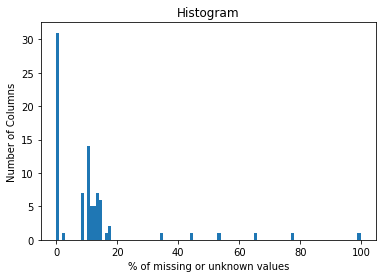

In [19]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(null_cols_per, bins=100)
plt.xlabel("% of missing or unknown values")
plt.ylabel("Number of Columns")
plt.title("Histogram")
plt.show()

In [20]:
null_cols_per.sort_values(ascending=True,inplace=True)
null_cols_per

ZABEOTYP                  0.000000
SEMIO_TRADV               0.000000
SEMIO_PFLICHT             0.000000
SEMIO_KAEM                0.000000
SEMIO_DOM                 0.000000
SEMIO_KRIT                0.000000
SEMIO_RAT                 0.000000
SEMIO_KULT                0.000000
SEMIO_ERL                 0.000000
SEMIO_LUST                0.000000
SEMIO_VERT                0.000000
SEMIO_MAT                 0.000000
SEMIO_REL                 0.000000
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
FINANZ_VORSORGER          0.000000
ANREDE_KZ                 0.000000
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
GREEN_AVANTGARDE          0.000000
FINANZTYP                 0.000000
ALTERSKATEGORIE_GROB      0.323264
GFK_URLAUBERTYP           0.544646
LP_STATUS_GROB            0.544646
LP_STATUS_FEIN            0.544646
ONLINE_AFFINITAET   

In [21]:
outlier_cols = null_cols_per[null_cols_per > null_cols_per["REGIOTYP"]].keys()
null_cols_per[null_cols_per > null_cols_per["REGIOTYP"]]

ALTER_HH        34.813699
GEBURTSJAHR     44.020282
KBA05_BAUMAX    53.468668
KK_KUNDENTYP    65.596749
AGER_TYP        76.955435
TITEL_KZ        99.757636
dtype: float64

In [22]:
list(outlier_cols)

['ALTER_HH',
 'GEBURTSJAHR',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'AGER_TYP',
 'TITEL_KZ']

In [23]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_cols = null_cols_per[null_cols_per > null_cols_per["REGIOTYP"]].keys()
print("This list of columns are outliers: \n{}\n Since most of the data have less than 18% null values".format(list(outlier_cols)) )

This list of columns are outliers: 
['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']
 Since most of the data have less than 18% null values


In [24]:
azdias = azdias.drop(outlier_cols, axis=1)

In [25]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

- Most of the columns found in azdias have less than 18% null values.
- All columns that have a percentage of null values which is greater than 18% are considered to be outlier features.
- The outlier features where remvoed from the azdias Data Frame.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?
null_rows = azdias.isnull().sum(axis=1)
null_rows.sort_values(ascending=True,inplace=True)
null_rows

445610     0
540274     0
540275     0
540277     0
540280     0
540281     0
540283     0
540284     0
540286     0
540273     0
540287     0
540290     0
540291     0
540292     0
540293     0
540295     0
540296     0
540298     0
540299     0
540289     0
540300     0
540271     0
540269     0
540239     0
540240     0
540241     0
540242     0
540243     0
540244     0
540246     0
          ..
139521    47
690887    47
690878    47
690876    47
690871    47
139478    47
139236    47
691118    47
691129    47
691317    47
139243    47
139245    47
139248    47
139250    47
139255    47
139267    47
691122    47
691212    47
139323    47
691197    47
139332    47
691183    47
691171    47
691142    47
691141    47
139316    47
183108    47
472919    48
732775    49
643174    49
Length: 891221, dtype: int64

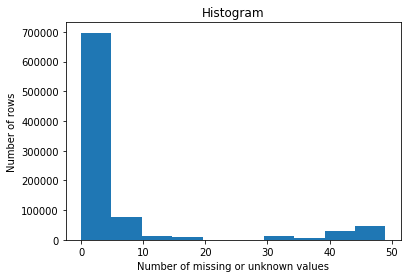

In [27]:
plt.hist(null_rows)
plt.xlabel("Number of missing or unknown values")
plt.ylabel("Number of rows")
plt.title("Histogram")
plt.show()

In [28]:
null_rows_per = null_rows*100/azdias.shape[1]
per_missing_rows = len(null_rows_per[null_rows_per!=0])/azdias.shape[0]*100
print("Percentage of rows that have missing data is {}%".format(round(per_missing_rows,2)))
print("Percentage of rows that have 0 missing data is {}%\n".format(100-round(per_missing_rows,2)))
print("That is a significant difference. Therfore a threshold must be chosen to decrease this gap")
print("The threshold chosen to create two subsets is 20")

Percentage of rows that have missing data is 30.07%
Percentage of rows that have 0 missing data is 69.93%

That is a significant difference. Therfore a threshold must be chosen to decrease this gap
The threshold chosen to create two subsets is 20


In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
rows_few_null = azdias[null_rows<20]
outlier_rows = azdias[null_rows_per>20]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [30]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
complete_cols = list(null_cols_per[null_cols_per==0].index)
seven_complete_cols = complete_cols[:7]
seven_complete_cols

['ZABEOTYP',
 'SEMIO_TRADV',
 'SEMIO_PFLICHT',
 'SEMIO_KAEM',
 'SEMIO_DOM',
 'SEMIO_KRIT',
 'SEMIO_RAT']

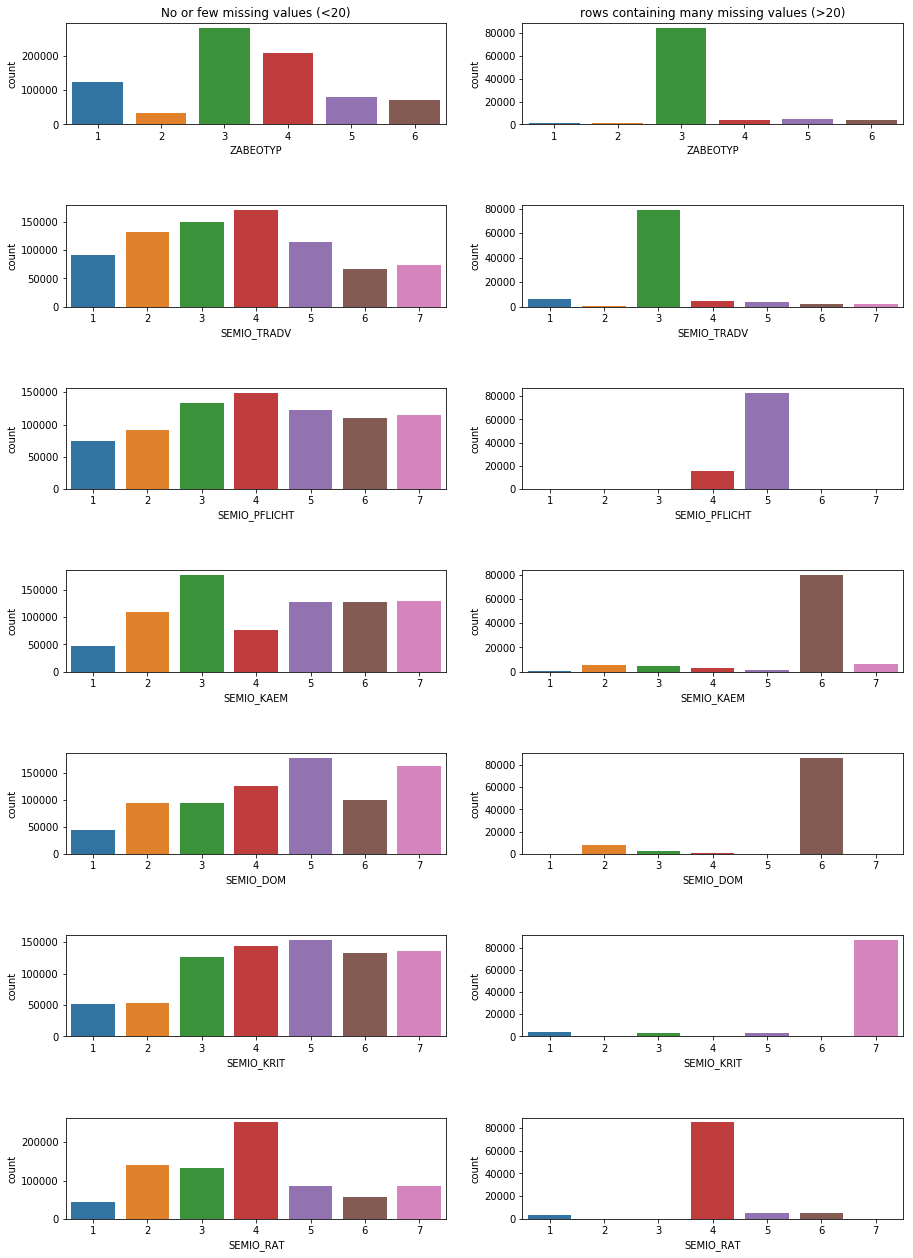

In [31]:
figure, axs = plt.subplots(ncols=2, nrows = len(seven_complete_cols),figsize = (15,22))
figure.subplots_adjust(hspace = .8, wspace=.2)
for indx, row_plot in enumerate(seven_complete_cols):
    if indx==0:
        axs[0][0].set_title('No or few missing values (<20)')
    sns.countplot(rows_few_null[row_plot],ax=axs[indx][0])
    if indx == 0:
        axs[0][1].set_title('rows containing many missing values (>20)')
    sns.countplot(outlier_rows[row_plot], ax=axs[indx][1])

#### Discussion 1.1.3: Assess Missing Data in Each Row

The data with lots of missing values are qualitatively different from the data with few or no missing values. This is eveident in the seaborn bar chart above.
The charts on the right signify to a polarizing number of missing values, whereas the bar charts on the left follow a certain distribution (probably a normal distribution).

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
feat_info.iloc[0]

attribute                AGER_TYP
information_level          person
type                  categorical
missing_or_unknown         [-1,0]
Name: 0, dtype: object

In [33]:
feat_info.shape[0]

85

In [34]:
# How many features are there of each data type?
filter_outlier_columns = feat_info[feat_info['attribute'].isin(list(rows_few_null.columns))]
filter_outlier_columns.groupby(["type"]).size()

type
categorical    18
mixed           6
numeric         6
ordinal        49
dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [35]:
filter_outlier_columns.head()

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]


In [36]:
cat_rows = filter_outlier_columns[filter_outlier_columns["type"]=="categorical"]

In [37]:
# binary (two-level) categoricals that take numeric values example
rows_few_null.groupby(["ANREDE_KZ"]).size()#.reset_index(name='count')

ANREDE_KZ
1    381499
2    415578
dtype: int64

In [38]:
# There is one binary variable that takes on non-numeric values.
rows_few_null.groupby(["OST_WEST_KZ"]).size()

OST_WEST_KZ
O    168382
W    628695
dtype: int64

In [39]:
# multi-level categoricals example
rows_few_null.groupby(["CJT_GESAMTTYP"]).size()

CJT_GESAMTTYP
1.0     93192
2.0    141166
3.0    147068
4.0    198089
5.0    111032
6.0    101898
dtype: int64

In [40]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binary_cat = []
multi_lvl = []
for cols in cat_rows["attribute"]:
    if len(rows_few_null.groupby([cols]).size()) == 2:
        binary_cat.append(cols)
    else:
        multi_lvl.append(cols)

In [41]:
for col in binary_cat:
    print("{}\n".format(rows_few_null.groupby([col]).size()))

ANREDE_KZ
1    381499
2    415578
dtype: int64

GREEN_AVANTGARDE
0    621942
1    175135
dtype: int64

SOHO_KZ
0.0    790370
1.0      6707
dtype: int64

VERS_TYP
1.0    366623
2.0    394116
dtype: int64

OST_WEST_KZ
O    168382
W    628695
dtype: int64



In [42]:
list(rows_few_null.groupby([binary_cat[0]]).size().keys())

[1, 2]

In [43]:
# Re-encode categorical variable(s) to be kept in the analysis.
for i in binary_cat:
    keys = list(rows_few_null.groupby([i]).size().keys())
    rows_few_null[i].replace({keys[0]:0,keys[1]:1},inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [44]:
for col in binary_cat:
    print("{}\n".format(rows_few_null.groupby([col]).size()))

ANREDE_KZ
0    381499
1    415578
dtype: int64

GREEN_AVANTGARDE
0    621942
1    175135
dtype: int64

SOHO_KZ
0.0    790370
1.0      6707
dtype: int64

VERS_TYP
0.0    366623
1.0    394116
dtype: int64

OST_WEST_KZ
0    168382
1    628695
dtype: int64



In [45]:
rows_few_null=pd.get_dummies(data=rows_few_null,columns=multi_lvl)

In [46]:
rows_few_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Columns: 194 entries, ALTERSKATEGORIE_GROB to CAMEO_DEU_2015_9E
dtypes: float64(42), int64(23), object(1), uint8(128)
memory usage: 524.7+ MB


#### Discussion 1.2.1: Re-Encode Categorical Features

- I found the different types of categorical variables.
- I changed the binary ones manually in a for loop (including the non-numeric ones)
- I then used pd.get_dummies to change the multi-variable categorical features

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
* "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.

### PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [47]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
rows_few_null["PRAEGENDE_JUGENDJAHRE"].head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [48]:
rows_few_null['MOVEMENT'] = rows_few_null['PRAEGENDE_JUGENDJAHRE']
rows_few_null['DECADE'] = rows_few_null['PRAEGENDE_JUGENDJAHRE']

In [49]:
string_prae_jugend = """1: 40s  war years (Mainstream, E+W)
-2: 40s  reconstruction years (Avantgarde, E+W)
-3: 50s  economic miracle (Mainstream, E+W)
-4: 50s  milk bar / Individualisation (Avantgarde, E+W)
-5: 60s  economic miracle (Mainstream, E+W)
-6: 60s  generation 68 / student protestors (Avantgarde, W)
-7: 60s  opponents to the building of the Wall (Avantgarde, E)
-8: 70s  family orientation (Mainstream, E+W)
-9: 70s  peace movement (Avantgarde, E+W)
-10: 80s  Generation Golf (Mainstream, W)
-11: 80s  ecological awareness (Avantgarde, W)
-12: 80s  FDJ / communist party youth organisation (Mainstream, E)
-13: 80s  Swords into ploughshares (Avantgarde, E)
-14: 90s  digital media kids (Mainstream, E+W)
-15: 90s  ecological awareness (Avantgarde, E+W)"""

In [50]:
data_dict_list = string_prae_jugend.split("-")

In [51]:
# Make a binary dict for Movement (Mainstream = 0, Avantgarde = 1)
move_dict = {}
movement ={"Mainstream":0, "Avantgarde":1}
for entry in data_dict_list:
    entry = entry.split(":")
    if "Mainstream" in entry[1]:
        move_dict[int(entry[0])] = movement["Mainstream"]
    elif "Avantgarde" in entry[1]:
        move_dict[int(entry[0])] = movement["Avantgarde"]
move_dict

{1: 0,
 2: 1,
 3: 0,
 4: 1,
 5: 0,
 6: 1,
 7: 1,
 8: 0,
 9: 1,
 10: 0,
 11: 1,
 12: 0,
 13: 1,
 14: 0,
 15: 1}

In [52]:
data_dict_list[0][:data_dict_list[0].index("s")]

'1: 40'

In [53]:
#data_dict_list_filter = [[:entry["s"]] for entry in data_dict_list]
decade_list = []
for entry in range(len(data_dict_list)):
    dummy_list = data_dict_list[entry][:data_dict_list[entry].index("s")]
    dummy_list = dummy_list[dummy_list.index(" "):]
    decade_list.append(int(dummy_list))
decade_list

[40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]

In [54]:
decade_list_unique = list(sorted(set(decade_list)))
decade_set_dict = {}
for entry in range(len(decade_list_unique)):
    decade_set_dict[decade_list_unique[entry]]=entry+1
decade_set_dict

{40: 1, 50: 2, 60: 3, 70: 4, 80: 5, 90: 6}

In [55]:
decade_dict = {}
for entry in range(1,len(decade_list)+1):
    decade_dict[entry] = decade_set_dict[decade_list[entry-1]]
decade_dict

{1: 1,
 2: 1,
 3: 2,
 4: 2,
 5: 3,
 6: 3,
 7: 3,
 8: 4,
 9: 4,
 10: 5,
 11: 5,
 12: 5,
 13: 5,
 14: 6,
 15: 6}

In [56]:
rows_few_null['MOVEMENT'].replace(move_dict, inplace=True)
rows_few_null['DECADE'].replace(decade_dict, inplace=True)

* "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
* If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

### CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [57]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
rows_few_null['WEALTH'] = rows_few_null['CAMEO_INTL_2015']
rows_few_null['LIFE_STAGE'] = rows_few_null['CAMEO_INTL_2015']

In [58]:
string_cam = """11: Wealthy Households - Pre-Family Couples & Singles
12: Wealthy Households - Young Couples With Children
13: Wealthy Households - Families With School Age Children
14: Wealthy Households - Older Families & Mature Couples
15: Wealthy Households - Elders In Retirement
21: Prosperous Households - Pre-Family Couples & Singles
22: Prosperous Households - Young Couples With Children
23: Prosperous Households - Families With School Age Children
24: Prosperous Households - Older Families & Mature Couples
25: Prosperous Households - Elders In Retirement
31: Comfortable Households - Pre-Family Couples & Singles
32: Comfortable Households - Young Couples With Children
33: Comfortable Households - Families With School Age Children
34: Comfortable Households - Older Families & Mature Couples
35: Comfortable Households - Elders In Retirement
41: Less Affluent Households - Pre-Family Couples & Singles
42: Less Affluent Households - Young Couples With Children
43: Less Affluent Households - Families With School Age Children
44: Less Affluent Households - Older Families & Mature Couples
45: Less Affluent Households - Elders In Retirement
51: Poorer Households - Pre-Family Couples & Singles
52: Poorer Households - Young Couples With Children
53: Poorer Households - Families With School Age Children
54: Poorer Households - Older Families & Mature Couples
55: Poorer Households - Elders In Retirement"""

In [59]:
string_cam = string_cam.split("\n")
string_cam

['11: Wealthy Households - Pre-Family Couples & Singles',
 '12: Wealthy Households - Young Couples With Children',
 '13: Wealthy Households - Families With School Age Children',
 '14: Wealthy Households - Older Families & Mature Couples',
 '15: Wealthy Households - Elders In Retirement',
 '21: Prosperous Households - Pre-Family Couples & Singles',
 '22: Prosperous Households - Young Couples With Children',
 '23: Prosperous Households - Families With School Age Children',
 '24: Prosperous Households - Older Families & Mature Couples',
 '25: Prosperous Households - Elders In Retirement',
 '31: Comfortable Households - Pre-Family Couples & Singles',
 '32: Comfortable Households - Young Couples With Children',
 '33: Comfortable Households - Families With School Age Children',
 '34: Comfortable Households - Older Families & Mature Couples',
 '35: Comfortable Households - Elders In Retirement',
 '41: Less Affluent Households - Pre-Family Couples & Singles',
 '42: Less Affluent Households - Y

In [60]:
wealth_dict = {}
wealth ={"Wealthy":1, "Prosperous":2, "Comfortable":3, "Less Affluent":4, "Poorer":5}
for entry in string_cam:
    entry = entry.split(":")
    if "Wealthy" in entry[1]:
        wealth_dict[entry[0]] = wealth["Wealthy"]
    elif "Prosperous" in entry[1]:
        wealth_dict[entry[0]] = wealth["Prosperous"]
    elif "Comfortable" in entry[1]:
        wealth_dict[entry[0]] = wealth["Comfortable"]
    elif "Less Affluent" in entry[1]:
        wealth_dict[entry[0]] = wealth["Less Affluent"]
    elif "Poorer" in entry[1]:
        wealth_dict[entry[0]] = wealth["Poorer"]
wealth_dict

{'11': 1,
 '12': 1,
 '13': 1,
 '14': 1,
 '15': 1,
 '21': 2,
 '22': 2,
 '23': 2,
 '24': 2,
 '25': 2,
 '31': 3,
 '32': 3,
 '33': 3,
 '34': 3,
 '35': 3,
 '41': 4,
 '42': 4,
 '43': 4,
 '44': 4,
 '45': 4,
 '51': 5,
 '52': 5,
 '53': 5,
 '54': 5,
 '55': 5}

In [61]:
life_stage_dict = {}
life_stages ={"Singles":1, "Young":2, "School":3, "Older":4, "Retirement":5}
for entry in string_cam:
    entry = entry.split(":")
    if "Singles" in entry[1]:
        life_stage_dict[entry[0]] = life_stages["Singles"]
    elif "Young" in entry[1]:
        life_stage_dict[entry[0]] = life_stages["Young"]
    elif "School" in entry[1]:
        life_stage_dict[entry[0]] = life_stages["School"]
    elif "Older" in entry[1]:
        life_stage_dict[entry[0]] = life_stages["Older"]
    elif "Retirement" in entry[1]:
        life_stage_dict[entry[0]] = life_stages["Retirement"]
life_stage_dict

{'11': 1,
 '12': 2,
 '13': 3,
 '14': 4,
 '15': 5,
 '21': 1,
 '22': 2,
 '23': 3,
 '24': 4,
 '25': 5,
 '31': 1,
 '32': 2,
 '33': 3,
 '34': 4,
 '35': 5,
 '41': 1,
 '42': 2,
 '43': 3,
 '44': 4,
 '45': 5,
 '51': 1,
 '52': 2,
 '53': 3,
 '54': 4,
 '55': 5}

In [62]:
rows_few_null['WEALTH'].replace(wealth_dict, inplace=True)
rows_few_null['LIFE_STAGE'].replace(life_stage_dict, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I decided to keep the two mixed-features:
- PRAEGENDE_JUGENDJAHRE
- CAMEO_INTL_2015
In order to train more in the data preperation stage.
<br>

Since python is such an amazing automating tool, I assumed that the Data_dictionary file requirements for the two columns are data themselves, and saved the information as a string variable for extraction purposes.
<br>
Then I created two columns for each mixed-feature, and extracted the necessary information that classify the different cases. The case types are saved in dictionaries, and are used to map the values in the columns to their respective transformations

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [63]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [64]:
mixed_features = filter_outlier_columns[filter_outlier_columns["type"]=="mixed"]["attribute"]
mixed_features

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [65]:
len(rows_few_null.columns)

198

In [66]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
for mix in mixed_features:
    if mix in rows_few_null.columns:
        rows_few_null.drop(mix,axis=1,inplace=True)
len(rows_few_null.columns)

192

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [67]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for row in range(len(feat_info)):
        content = feat_info.iloc[row]['missing_or_unknown'].strip('[]').split(",")
        for idx, contents in enumerate(content):
            if contents != "" and contents != "X" and contents != "XX":
                content[idx] = int(contents)
        if content != ['']:
            df = df.replace({feat_info.iloc[row]['attribute']: content}, np.nan)

    # remove selected columns and rows, ...
    null_cols = df.isnull().sum()
    null_cols_per = null_cols*100/df.shape[0]
    
    outlier_cols = null_cols_per[null_cols_per > null_cols_per["REGIOTYP"]].keys()
    df = df.drop(outlier_cols, axis=1)
    
    null_rows = df.isnull().sum(axis=1)
    df = df[null_rows<20]

    # select, re-encode, and engineer column values.
    filter_outlier_columns = feat_info[feat_info['attribute'].isin(df.columns)]
    #filter_outlier_columns.groupby(["type"]).size()
    
    cat_rows = filter_outlier_columns[filter_outlier_columns["type"]=="categorical"]

    binary_cat = []
    multi_lvl = []
    for cols in cat_rows["attribute"]:
        if len(df.groupby([cols]).size()) == 2:
            binary_cat.append(cols)
        else:
            multi_lvl.append(cols)
            
    for i in binary_cat:
        keys = list(df.groupby([i]).size().keys())
        df[i].replace({keys[0]:0,keys[1]:1},inplace=True)
        
    df = pd.get_dummies(data=df,columns=multi_lvl)
    
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    
    string_prae_jugend = """1: 40s  war years (Mainstream, E+W)
    -2: 40s  reconstruction years (Avantgarde, E+W)
    -3: 50s  economic miracle (Mainstream, E+W)
    -4: 50s  milk bar / Individualisation (Avantgarde, E+W)
    -5: 60s  economic miracle (Mainstream, E+W)
    -6: 60s  generation 68 / student protestors (Avantgarde, W)
    -7: 60s  opponents to the building of the Wall (Avantgarde, E)
    -8: 70s  family orientation (Mainstream, E+W)
    -9: 70s  peace movement (Avantgarde, E+W)
    -10: 80s  Generation Golf (Mainstream, W)
    -11: 80s  ecological awareness (Avantgarde, W)
    -12: 80s  FDJ / communist party youth organisation (Mainstream, E)
    -13: 80s  Swords into ploughshares (Avantgarde, E)
    -14: 90s  digital media kids (Mainstream, E+W)
    -15: 90s  ecological awareness (Avantgarde, E+W)"""
    
    data_dict_list = string_prae_jugend.split("-")
    move_dict = {}
    movement ={"Mainstream":0, "Avantgarde":1}
    for entry in data_dict_list:
        entry = entry.split(":")
        if "Mainstream" in entry[1]:
            move_dict[int(entry[0])] = movement["Mainstream"]
        elif "Avantgarde" in entry[1]:
            move_dict[int(entry[0])] = movement["Avantgarde"]
            
    decade_list = []
    for entry in range(len(data_dict_list)):
        dummy_list = data_dict_list[entry][:data_dict_list[entry].index("s")]
        dummy_list = dummy_list[dummy_list.index(" "):]
        decade_list.append(int(dummy_list))
        
    decade_list_unique = list(sorted(set(decade_list)))
    decade_set_dict = {}
    for entry in range(len(decade_list_unique)):
        decade_set_dict[decade_list_unique[entry]]=entry+1

    decade_dict = {}
    for entry in range(1,len(decade_list)+1):
        decade_dict[entry] = decade_set_dict[decade_list[entry-1]]

    df['MOVEMENT'].replace(move_dict, inplace=True)
    df['DECADE'].replace(decade_dict, inplace=True)

    string_cam = """11: Wealthy Households - Pre-Family Couples & Singles
    12: Wealthy Households - Young Couples With Children
    13: Wealthy Households - Families With School Age Children
    14: Wealthy Households - Older Families & Mature Couples
    15: Wealthy Households - Elders In Retirement
    21: Prosperous Households - Pre-Family Couples & Singles
    22: Prosperous Households - Young Couples With Children
    23: Prosperous Households - Families With School Age Children
    24: Prosperous Households - Older Families & Mature Couples
    25: Prosperous Households - Elders In Retirement
    31: Comfortable Households - Pre-Family Couples & Singles
    32: Comfortable Households - Young Couples With Children
    33: Comfortable Households - Families With School Age Children
    34: Comfortable Households - Older Families & Mature Couples
    35: Comfortable Households - Elders In Retirement
    41: Less Affluent Households - Pre-Family Couples & Singles
    42: Less Affluent Households - Young Couples With Children
    43: Less Affluent Households - Families With School Age Children
    44: Less Affluent Households - Older Families & Mature Couples
    45: Less Affluent Households - Elders In Retirement
    51: Poorer Households - Pre-Family Couples & Singles
    52: Poorer Households - Young Couples With Children
    53: Poorer Households - Families With School Age Children
    54: Poorer Households - Older Families & Mature Couples
    55: Poorer Households - Elders In Retirement"""
    
    df['WEALTH'] = df['CAMEO_INTL_2015']
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']
    
    string_cam = string_cam.split("\n")
    
    wealth_dict = {}
    wealth ={"Wealthy":1, "Prosperous":2, "Comfortable":3, "Less Affluent":4, "Poorer":5}
    for entry in string_cam:
        entry = entry.split(":")
        if "Wealthy" in entry[1]:
            wealth_dict[entry[0]] = wealth["Wealthy"]
        elif "Prosperous" in entry[1]:
            wealth_dict[entry[0]] = wealth["Prosperous"]
        elif "Comfortable" in entry[1]:
            wealth_dict[entry[0]] = wealth["Comfortable"]
        elif "Less Affluent" in entry[1]:
            wealth_dict[entry[0]] = wealth["Less Affluent"]
        elif "Poorer" in entry[1]:
            wealth_dict[entry[0]] = wealth["Poorer"]

    life_stage_dict = {}
    life_stages ={"Singles":1, "Young":2, "School":3, "Older":4, "Retirement":5}
    for entry in string_cam:
        entry = entry.split(":")
        if "Singles" in entry[1]:
            life_stage_dict[entry[0]] = life_stages["Singles"]
        elif "Young" in entry[1]:
            life_stage_dict[entry[0]] = life_stages["Young"]
        elif "School" in entry[1]:
            life_stage_dict[entry[0]] = life_stages["School"]
        elif "Older" in entry[1]:
            life_stage_dict[entry[0]] = life_stages["Older"]
        elif "Retirement" in entry[1]:
            life_stage_dict[entry[0]] = life_stages["Retirement"]

    df['WEALTH'].replace(wealth_dict, inplace=True)
    df['LIFE_STAGE'].replace(life_stage_dict, inplace=True)

    #create dict I will use it to re-engineer the mixed variables
    mixed_features = filter_outlier_columns[filter_outlier_columns["type"]=="mixed"]["attribute"]
    
    for mix in mixed_features:
        if mix in df.columns:
            df.drop(mix,axis=1,inplace=True)
    return df

In [68]:
azdias_test = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=';')

In [69]:
df=clean_data(azdias_test,feat_info)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Columns: 192 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(39), int64(23), object(2), uint8(128)
memory usage: 492.6+ MB


In [71]:
rows_few_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Columns: 192 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(41), int64(23), uint8(128)
memory usage: 512.6 MB


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [72]:
df.isnull().sum().sum()

745996

In [73]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
clean_missing = Imputer()
azdias_clean = clean_missing.fit_transform(df)
azdias_clean_df = pd.DataFrame(azdias_clean, 
                            columns=df.columns, 
                            index=df.index)

In [74]:
azdias_clean_df.isnull().sum().sum()

0

In [75]:
# Apply feature scaling to the general population demographics data.
ss = StandardScaler()
azdias_clean_ss = ss.fit_transform(azdias_clean_df)

In [76]:
azdias_clean_ss_df = pd.DataFrame(azdias_clean_ss, columns=azdias_clean_df.columns, index=azdias_clean_df.index)

In [77]:
azdias_clean_ss_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
1,-1.765596,0.958121,-1.494463,1.538139,-1.040664,1.466401,0.959974,1.338532,-0.530654,1.085338,...,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,-0.553082,1.165504,1.108884,1.108884
2,0.201448,0.958121,-1.494463,0.864753,-1.766903,-0.570914,0.245238,1.338532,1.884467,1.085338,...,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,1.874665,1.165504,-0.822604,-0.822604
3,1.184971,0.958121,0.683285,-0.482020,1.138052,-0.570914,-1.184235,-0.792444,-0.530654,-0.270203,...,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,-0.553082,-0.231903,-1.681043,-1.681043
4,0.201448,-1.043709,0.683285,0.191366,0.411813,-1.250019,0.245238,-0.792444,-0.530654,1.085338,...,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,-0.553082,-0.231903,0.536591,0.536591
5,-1.765596,0.958121,-0.042631,-1.155407,1.138052,-0.570914,-0.469499,1.338532,-0.530654,1.085338,...,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,-0.553082,-1.629311,1.323494,1.323494


### Discussion 2.1: Apply Feature Scaling

- I chose to use an Imupter to replace the Nan values using the mean along each column.
- Then I applied a StandardScaler to scale each feature to mean 0 and standard deviation 1. This is done so that the principal component vectors are not influenced by the natural differences in scale for features.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [78]:
pca = PCA()
pca.fit(azdias_clean_ss_df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

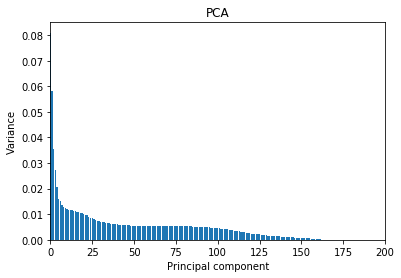

In [79]:
# Investigate the variance accounted for by each principal component.
num_comp=range(len(pca.explained_variance_ratio_))
val=pca.explained_variance_ratio_
plt.bar(num_comp,val) 
plt.xlabel("Principal component")
plt.xlim((0, 200)) 
plt.ylabel("Variance")
plt.title("PCA")
plt.show()

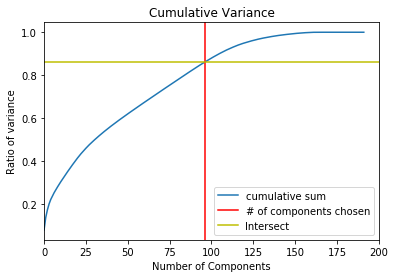

In [80]:
plt.plot(num_comp,np.cumsum(val), '-', label="cumulative sum")

chosen_comp = 96
plt.axvline(x=chosen_comp, color="red", label="# of components chosen")
plt.axhline(y=0.86, color="y", label="Intersect")
plt.title("Cumulative Variance")
plt.xlabel("Number of Components")
plt.xlim((0, 200)) 
plt.ylabel("Ratio of variance")
plt.legend()
plt.show()

In [81]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_96 = PCA(n_components=chosen_comp)
azdias_pca_96 = pca_96.fit_transform(azdias_clean_ss_df)

In [82]:
len(azdias_clean_ss_df.columns)/96

2.0

### Discussion 2.2: Perform Dimensionality Reduction

- I chose the number of compenents to retain to be 96.
- This decreases the number of features by half, while retaining a variance of 86%, this way we lose the least amount of information while removing a large chunck from our data

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [83]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, df, component):
    weights = pd.DataFrame(pca.components_, columns=list(df.columns))
    weights = weights.iloc[component].sort_values(ascending=False)
    return weights

In [84]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(pca_96, azdias_clean_ss_df, 0)

LP_STATUS_GROB_1.0      0.194668
LIFE_STAGE              0.188704
WEALTH                  0.188704
HH_EINKOMMEN_SCORE      0.187396
PLZ8_ANTG3              0.182307
PLZ8_ANTG4              0.175849
ORTSGR_KLS9             0.153823
EWDICHTE                0.152535
FINANZ_HAUSBAUER        0.150873
LP_STATUS_FEIN_1.0      0.129208
KBA05_ANTG4             0.127250
PLZ8_ANTG2              0.125508
ANZ_HAUSHALTE_AKTIV     0.116019
ARBEIT                  0.115468
KBA05_ANTG3             0.114975
CAMEO_DEUG_2015_9       0.113542
LP_STATUS_FEIN_2.0      0.111721
RELAT_AB                0.108427
FINANZTYP_1             0.107445
FINANZ_SPARER           0.106257
CAMEO_DEUG_2015_8       0.095305
LP_FAMILIE_FEIN_1.0     0.086637
LP_FAMILIE_GROB_1.0     0.086637
SEMIO_PFLICHT           0.076326
ZABEOTYP_5              0.072408
SEMIO_REL               0.071845
GEBAEUDETYP_3.0         0.066588
DECADE                  0.064338
CAMEO_DEU_2015_8A       0.063484
REGIOTYP                0.063203
          

In [85]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(pca_96, azdias_clean_ss_df, 1)


ALTERSKATEGORIE_GROB     0.236719
FINANZ_VORSORGER         0.222602
ZABEOTYP_3               0.200246
SEMIO_ERL                0.181530
SEMIO_LUST               0.165747
RETOURTYP_BK_S           0.155804
W_KEIT_KIND_HH           0.125074
CJT_GESAMTTYP_2.0        0.110144
FINANZTYP_5              0.097073
FINANZ_MINIMALIST        0.096551
FINANZTYP_2              0.095167
LP_STATUS_FEIN_1.0       0.090784
FINANZ_HAUSBAUER         0.080015
SHOPPER_TYP_3.0          0.074838
CJT_GESAMTTYP_1.0        0.071333
SEMIO_KRIT               0.070783
FINANZTYP_6              0.069703
NATIONALITAET_KZ_1.0     0.069239
GFK_URLAUBERTYP_4.0      0.058300
WEALTH                   0.058045
LIFE_STAGE               0.058045
WOHNDAUER_2008           0.057685
PLZ8_ANTG3               0.056833
EWDICHTE                 0.055936
ORTSGR_KLS9              0.054689
LP_FAMILIE_GROB_1.0      0.054679
LP_FAMILIE_FEIN_1.0      0.054679
SEMIO_KAEM               0.054490
PLZ8_ANTG4               0.053200
LP_STATUS_FEIN

In [86]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(pca_96, azdias_clean_ss_df, 2)


SEMIO_VERT               0.319498
SEMIO_FAM                0.261403
SEMIO_SOZ                0.257524
SEMIO_KULT               0.252630
FINANZTYP_5              0.133992
FINANZ_MINIMALIST        0.129180
SHOPPER_TYP_0.0          0.123495
ZABEOTYP_1               0.117019
SEMIO_REL                0.114227
SEMIO_MAT                0.089415
RETOURTYP_BK_S           0.074343
GREEN_AVANTGARDE         0.073308
MOVEMENT                 0.070944
W_KEIT_KIND_HH           0.067353
EWDICHTE                 0.060823
ORTSGR_KLS9              0.060778
SHOPPER_TYP_1.0          0.054912
LP_STATUS_GROB_5.0       0.051359
LP_STATUS_FEIN_10.0      0.051359
ZABEOTYP_6               0.049587
PLZ8_ANTG4               0.047330
PLZ8_ANTG3               0.047251
FINANZ_VORSORGER         0.046370
LP_STATUS_FEIN_3.0       0.044295
LP_STATUS_FEIN_1.0       0.042268
PLZ8_ANTG2               0.034429
RELAT_AB                 0.034032
ARBEIT                   0.033278
LP_STATUS_GROB_3.0       0.032300
GEBAEUDETYP_3.

### Discussion 2.3: Interpret Principal Components

1. Mapped weights for the first principal component corresponding to feature names:
    - positive values
        - LP_STATUS_GROB_1.0 (Social status - low-income earners)
        - HH_EINKOMMEN_SCORE (Estimated household net income)
        - WEALTH(Households wealth)
    - negative values
        - FINANZ_MINIMALIST(Financial typology:low financial interest)
        - KBA05_GBZ(Number of buildings in the microcell)
        - MOBI_REGIO(Movement patterns)

<br>
we can notice the first component is proportional to low-income earners, household net income and wealth. Negative values indicate an inverse relationship with the component.

2. Mapped weights for the second principal component corresponding to feature names:
    - positive values
        - ALTERSKATEGORIE_GROB (Person-level features - Estimated age based on given name analysis)
        - FINANZ_VORSORGER (Financial typology, for each dimension: high)
        - ZABEOTYP_3(Energy consumption typology = fair supplied)
    - negative values
        - DECADE
        - FINANZ_SPARER(Financial typology, for each dimension: very high)
        - FINANZ_UNAUFFAELLIGER(Movement Financial typology, for each dimension: low)

<br>
we can notice the second component is proportional to the age of the individual, a financially precautionary and a fairly supplied person. Negative values indicate an inverse relationship with the component.

3. Mapped weights for the third principal component corresponding to feature names:
    - positive values
        - SEMIO_VERT (Personality typology - Dimension translations: dreamful)
        - SEMIO_FAM (Personality typology - Dimension translations: family-minded)
        - SEMIO_SOZ(Personality typology - Dimension translations: socially-minded)
    - negative values
        - ANREDE_KZ(Gender)
        - SEMIO_KAEM(Personality typology - Dimension translations: combative attitude)
        - SEMIO_DOM(Personality typology - Dimension translations: dominant-minded)

<br>
we can notice the third component is proportional to Personality types: dreamful, family-minded and socially-minded. Negative values indicate an inverse relationship with the component.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [87]:
from sklearn.cluster import MiniBatchKMeans

In [145]:
# Over a number of different cluster counts...
scorer = []
clusters = np.arange(2,21)
for centers in clusters:
    kmeans = MiniBatchKMeans(centers)
    model = kmeans.fit(azdias_pca_96)
    scorer.append(np.abs(model.score(azdias_pca_96)))

    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

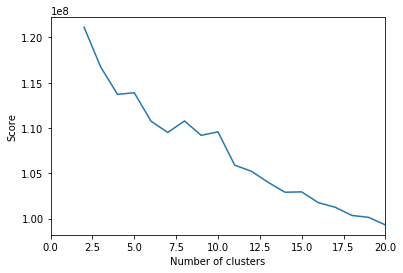

In [146]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters, scorer)
plt.xlabel('Number of clusters')
plt.xlim(0,20)
plt.ylabel('Score')
plt.show()


In [147]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = MiniBatchKMeans(n_clusters=19)
model_19=kmeans.fit(azdias_pca_96)
azdias_pred=model_19.predict(azdias_pca_96)

### Discussion 3.1: Apply Clustering to General Population

- The elbow of the plot is seen when the number of clusters is 19. So the data is best classified with 19 clusters.
- I chose to use MiniBatchKMeans instead of KMeans since it took more than an hour to compute. (due to the large dataset)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [148]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [149]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers, feat_info)

In [150]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141590 entries, 0 to 191651
Columns: 191 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(39), int64(23), object(2), uint8(127)
memory usage: 87.4+ MB


In [151]:
customers.isnull().sum().sum()

102081

In [152]:
def add_missing_dummy_columns(d, columns):
    missing_cols = set(columns) - set(d.columns)
    print(missing_cols)
    for c in missing_cols:
        d[c] = 0
           
def fix_columns(d, columns):  
    add_missing_dummy_columns(d, columns)
    # make sure we have all the columns we need
    assert(set(columns) - set(d.columns) == set())
    extra_cols = set(d.columns) - set(columns)
    if extra_cols:
        print("extra columns:", extra_cols)
    d = d[columns]
    return d
customers_clean_ss_df = fix_columns(customers, df.columns.tolist())

{'GEBAEUDETYP_5.0'}


In [153]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# clean_missing_cus = Imputer()
customers_clean = clean_missing.transform(customers)
customers_clean_df = pd.DataFrame(customers_clean, 
                            columns=customers.columns, 
                            index=customers.index)

In [154]:
customers_clean_df.isnull().sum().sum()

0

In [155]:
# Apply feature scaling to the general population demographics data.
# ss_cus = StandardScaler()
customers_clean_ss = ss.transform(customers_clean_df)
customers_clean_ss_df = pd.DataFrame(customers_clean_ss, columns=customers_clean_df.columns, index=customers_clean_df.index)

customers_pca = pca_96.transform(customers_clean_ss_df)

In [156]:
pred_customers= model_19.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

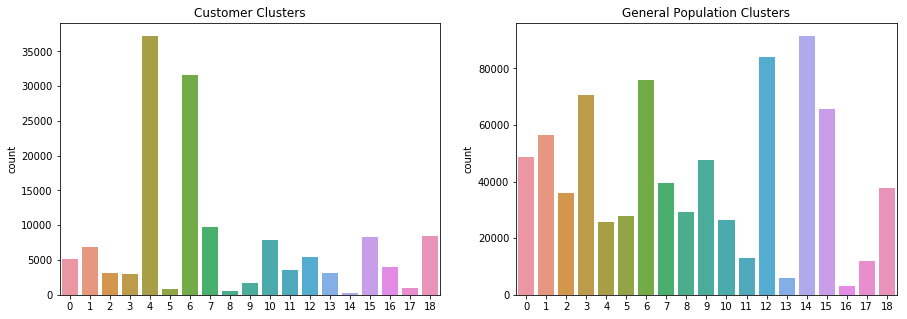

In [157]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(ncols=2, nrows=1, figsize = (15,5))
figure.subplots_adjust(hspace = .8, wspace=.2)

sns.countplot(pred_customers, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General Population Clusters')
plt.show()

In [181]:
pca_weights(pca_96, customers_clean_ss_df, 16).head()

CAMEO_DEUG_2015_6      0.317489
LP_STATUS_FEIN_2.0     0.173767
SHOPPER_TYP_3.0        0.170507
CAMEO_DEUG_2015_8      0.157971
LP_FAMILIE_GROB_3.0    0.150873
Name: 16, dtype: float64

In [212]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_4 = ss.inverse_transform(pca_96.inverse_transform(model_19.cluster_centers_[4]))
centroid_16 = ss.inverse_transform(pca_96.inverse_transform(model_19.cluster_centers_[16]))

In [222]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroids_df = pd.DataFrame({"feature":customers_clean_ss_df.columns, 
                             "centroid4":centroid_4, 
                             "centroid16":centroid_16})

In [217]:
# taken from 2.3
pos_corr=["LP_STATUS_GROB_1.0","HH_EINKOMMEN_SCORE","WEALTH", "ALTERSKATEGORIE_GROB","FINANZ_VORSORGER","ZABEOTYP_3.0",
"SEMIO_VERT","SEMIO_FAM","SEMIO_SOZ"]
neg_corr=["FINANZ_MINIMALIST","MOBI_REGIO","KBA05_GBZ","DECADE","FINANZ_SPARER","FINANZ_UNAUFFAELLIGER",
             "SEMIO_KAEM","SEMIO_DOM","ANREDE_KZ"]

In [218]:
centroids_df[centroids_df["feature"].isin(pos_corr)]

,feature,centroid 4,centroid 16
0,ALTERSKATEGORIE_GROB,2.482471,2.866505
4,FINANZ_VORSORGER,2.412218,3.281285
11,SEMIO_SOZ,5.256448,3.959295
12,SEMIO_FAM,5.607915,4.148681
15,SEMIO_VERT,6.166171,5.168879
29,HH_EINKOMMEN_SCORE,2.413635,3.371734
110,LP_STATUS_GROB_1.0,0.008051,0.508420
189,WEALTH,5.394498,5.147650


In [219]:
centroids_df[centroids_df["feature"].isin(neg_corr)]

,feature,centroid 4,centroid 16
1,ANREDE_KZ,0.082915,0.310501
2,FINANZ_MINIMALIST,4.311545,3.432703
3,FINANZ_SPARER,3.304988,2.763855
6,FINANZ_UNAUFFAELLIGER,3.981062,3.501446
21,SEMIO_DOM,3.300608,3.993930
22,SEMIO_KAEM,2.815207,3.748831
41,KBA05_GBZ,3.758522,3.934581
47,MOBI_REGIO,3.796916,3.734114
188,DECADE,0.909475,0.481165


In [233]:
centroids_df[centroids_df["centroid4"]>4]

,feature,centroid4,centroid16
2,FINANZ_MINIMALIST,4.311545,3.432703
11,SEMIO_SOZ,5.256448,3.959295
12,SEMIO_FAM,5.607915,4.148681
13,SEMIO_REL,5.024242,3.598845
14,SEMIO_MAT,4.955303,3.063482
15,SEMIO_VERT,6.166171,5.168879
18,SEMIO_KULT,5.582991,4.260605
23,SEMIO_PFLICHT,4.509615,3.238929
24,SEMIO_TRADV,4.271021,3.722475
31,WOHNDAUER_2008,8.250103,7.468035


In [234]:
centroids_df[centroids_df["feature"]=="ANREDE_KZ"]

,feature,centroid4,centroid16
1,ANREDE_KZ,0.082915,0.310501


In [228]:
centroids_df[centroids_df["centroid16"]>4]

,feature,centroid4,centroid16
12,SEMIO_FAM,5.607915,4.148681
15,SEMIO_VERT,6.166171,5.168879
18,SEMIO_KULT,5.582991,4.260605
20,SEMIO_KRIT,3.394345,4.473237
31,WOHNDAUER_2008,8.250103,7.468035
35,MIN_GEBAEUDEJAHR,1996.723181,1995.482800
43,EWDICHTE,3.838644,5.412341
48,ONLINE_AFFINITAET,4.112312,4.533536
49,REGIOTYP,3.699946,4.177845
50,KBA13_ANZAHL_PKW,746.390786,880.572614


### Discussion 3.3: Compare Customer Data to Demographics Data
Based on above two plots we can say that,

The mail-order sales company is most popular with people in clusters 4, 5 and 7, while it is least popular with people in clusters 5, 8 and 14. One interesting thing about cluster 16 is that it is a fairly small cluster in the general population. Whereas, cluster 4 is overestimated compared to the general population.

The cluster centers for cluster 4 (for 13 principal components) as below:

In [214]:
centroid_4[:17]

array([ 2.48247078,  0.08291463,  4.31154515,  3.30498797,  2.4122175 ,
        2.75558255,  3.981062  ,  0.82114022,  0.90555928,  2.10031377,
        3.16461578,  5.25644761,  5.60791521,  5.02424239,  4.95530299,
        6.16617131,  3.69399068])

And cluster centers for 16 as below,

In [215]:
centroid_16[:17]

array([ 2.86650459,  0.31050051,  3.43270289,  2.76385481,  3.28128467,
        1.85045251,  3.50144563,  1.94775484,  0.49897927,  2.22003973,
        3.01785974,  3.95929515,  4.1486806 ,  3.5988452 ,  3.06348187,
        5.16887909,  3.25764294])

Then we can write the discussion section as below, by referencing to data dictionary and the weights of principal components ( Refer Step 2.3: Interpret Principal Components) as below,

Cluster 4 has its largest coefficients on: 
- SEMIO_VERT (Personality typology:dreamful) 
- SEMIO_SOZ (Personality typology:socially-minded)
- SEMIO_FAM (Personality typology:family-minded)
- FINANZ_MINIMALIST (minimalist financially)
- ANREDE_KZ(Male) = 0.082915
We conclude that the customer is a male, who has personality dreamful, socially-minded, family-minded, and is a minimalist.

Cluster 16 has its largest coefficients on: 
- ANREDE_KZ(Male) = 0.310501
- WOHNDAUER_2008 (Length of residence-length of residence 6-7 years) = 7.468035
- ORTSGR_KLS9(Size of community -  100,001 to 300,000 inhabitants) = 7.475146
- SEMIO_VERT (Personality typology:dreamful) 
- SEMIO_KRIT (Personality typology:critical-minded)
We conclude that the customer is a male, who has personality dreamful, critical-minded, lives in community of size (100,001 to 300,000 inhabitants) and have a lengthly residence of 6-7 years.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [235]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Identify_Customer_Segments.ipynb to html',
 '[NbConvertApp] Writing 687003 bytes to Identify_Customer_Segments.html']